# Option 1: Collaborative Filtering

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
# 1. Prepare data
df = pd.read_csv("Dataset.csv")

# 2. Group by Data to Rating
df_unique = df.groupby(['Gamer_ID', 'Game_Played'])['Personal_Rating'].mean().reset_index()

# 3. Create the User-Item Matrix
# Rows = Gamers, Columns = Games, Values = Ratings
user_item_matrix = df_unique.pivot(index='Gamer_ID', columns='Game_Played', values='Personal_Rating')

# 4. Fill missing values with 0 (assuming unplayed games have no rating)
user_item_matrix_filled = user_item_matrix.fillna(0)

# 5. Compute User Similarity Matrix using Cosine Similarity
user_sim = cosine_similarity(user_item_matrix_filled)
user_sim_df = pd.DataFrame(user_sim, index=user_item_matrix.index, columns=user_item_matrix.index)


In [21]:
# 6. Recommendation Function
def get_recommendations(target_gamer_id, num_recs=3):
    if target_gamer_id not in user_item_matrix.index:
        return "Gamer ID not found."
    
    # Get similarity scores for the target user and sort them
    similar_users = user_sim_df[target_gamer_id].sort_values(ascending=False).iloc[1:]
    
    # Get games the target user has already played
    played_games = user_item_matrix.loc[target_gamer_id].dropna().index.tolist()
    
    recommendation_scores = pd.Series(dtype='float64')
    
    for other_user, similarity in similar_users.items():
        if similarity <= 0: continue
        
        # Get ratings from the similar user
        other_user_ratings = user_item_matrix.loc[other_user].dropna()
        
        # Find games the target user hasn't played yet
        new_games = other_user_ratings.index.difference(played_games)
        
        # Weight the ratings by the user similarity score
        weighted_ratings = other_user_ratings[new_games] * similarity
        recommendation_scores = recommendation_scores.add(weighted_ratings, fill_value=0)
        
    return recommendation_scores.sort_values(ascending=False).head(num_recs)



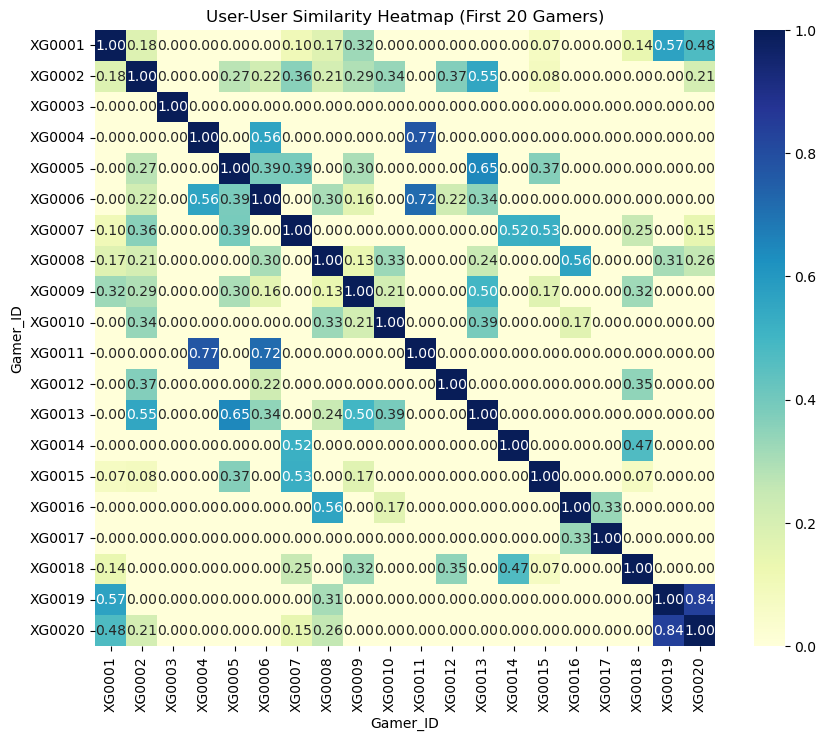

In [22]:
# 7. Heat Map Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(user_sim_df.iloc[:20, :20], annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('User-User Similarity Heatmap (First 20 Gamers)')
plt.show
plt.savefig('Collab Heatmap.png')

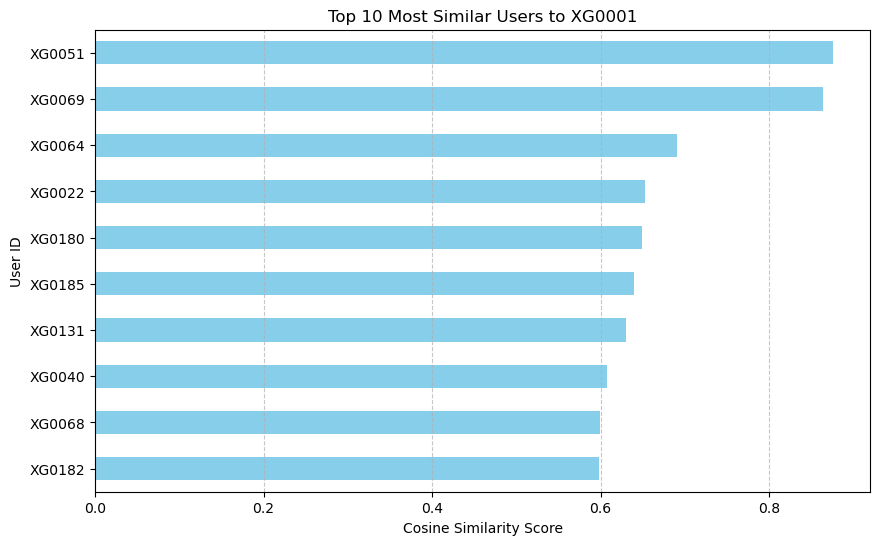

<Figure size 640x480 with 0 Axes>

In [23]:
# 8. Bar Chart Visualization
target_user = user_sim_df.index[0]
top_sim_users = user_sim_df[target_user].drop(target_user).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_sim_users.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()  # Put the most similar at the top
plt.title(f'Top 10 Most Similar Users to {target_user}')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('User ID')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
plt.savefig('Collab Similar.png')

In [24]:
# --- Example Usage ---
gamer_id = "XG0001"
recommendations = get_recommendations(gamer_id)
print(f"Top recommendations for {gamer_id}:")
print(recommendations)

Top recommendations for XG0001:
Game_Played
Elden Ring                       28.888480
Ori and the Will of the Wisps    25.040765
Flight Simulator                 25.039620
dtype: float64


# Option 2: Content-Based Approach with 798 Users and Genre & Title

In [25]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [26]:
# 1. Data Preparation
df = pd.read_csv('Dataset.csv')
# Aggregate duplicate entries (e.g., same user playing the same game)
df_cleaned = df.groupby(['Gamer_ID', 'Game_Played', 'Genre']).agg({
    'Personal_Rating': 'mean'
}).reset_index()

# 2. Build Item-Feature Matrix (Games vs Genres)
game_to_genre = df_cleaned[['Game_Played', 'Genre']].drop_duplicates().set_index('Game_Played')
game_genre_matrix = pd.get_dummies(game_to_genre['Genre'])

# 3. Recommendation Function
def recommend_games(gamer_id, df_cleaned, game_genre_matrix, top_n=3):
    # Get user history
    user_data = df_cleaned[df_cleaned['Gamer_ID'] == gamer_id]
    user_ratings = user_data.set_index('Game_Played')['Personal_Rating']
    
    # Create User Profile (weighted average of genres based on ratings)
    user_game_genres = game_genre_matrix.loc[user_ratings.index]
    user_profile = np.dot(user_ratings.values, user_game_genres.values)
    
    # Calculate similarity between user profile and all games
    scores = cosine_similarity(user_profile.reshape(1, -1), game_genre_matrix.values).flatten()
    
    # Filter out games already played
    recommendations = pd.DataFrame({
        'Game': game_genre_matrix.index,
        'Similarity_Score': scores
    })
    played_games = user_data['Game_Played'].unique()
    recommendations = recommendations[~recommendations['Game'].isin(played_games)]
    
    return recommendations.sort_values(by='Similarity_Score', ascending=False).head(top_n)

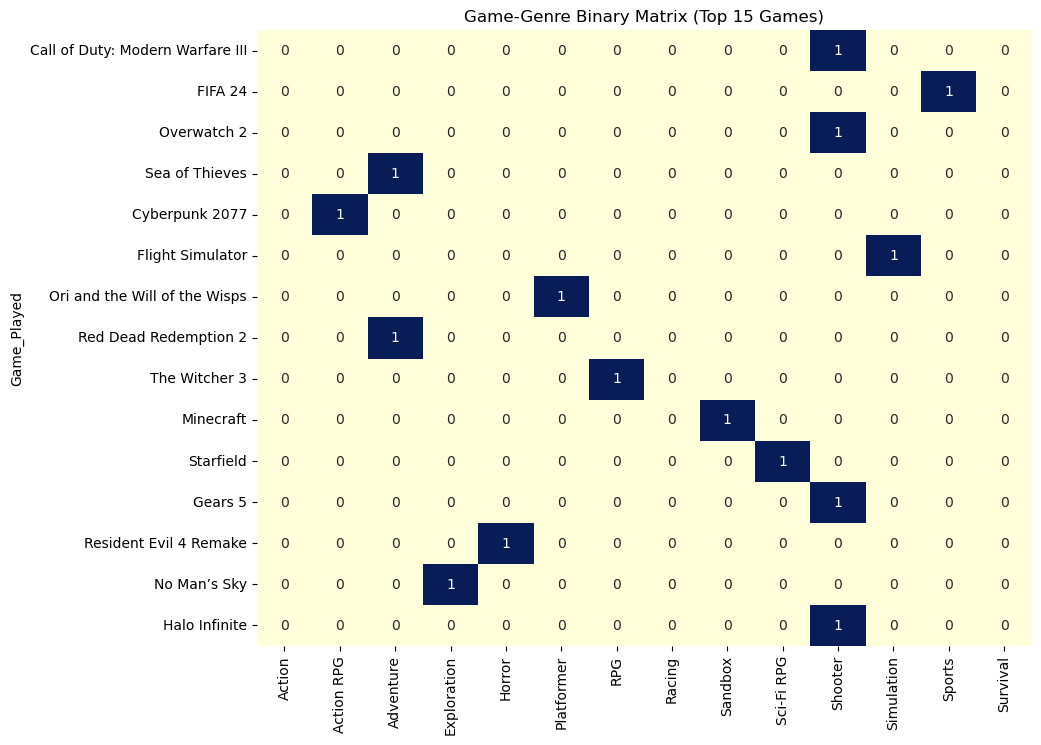

<Figure size 640x480 with 0 Axes>

In [27]:
# 4. Heat Map Visualization (Game vs Genre)
plt.figure(figsize=(10, 8))
sns.heatmap(game_genre_matrix.head(15), annot=True, cmap="YlGnBu", cbar=False)
plt.title("Game-Genre Binary Matrix (Top 15 Games)")
plt.show()
plt.savefig('Content Heatmap 1.png')

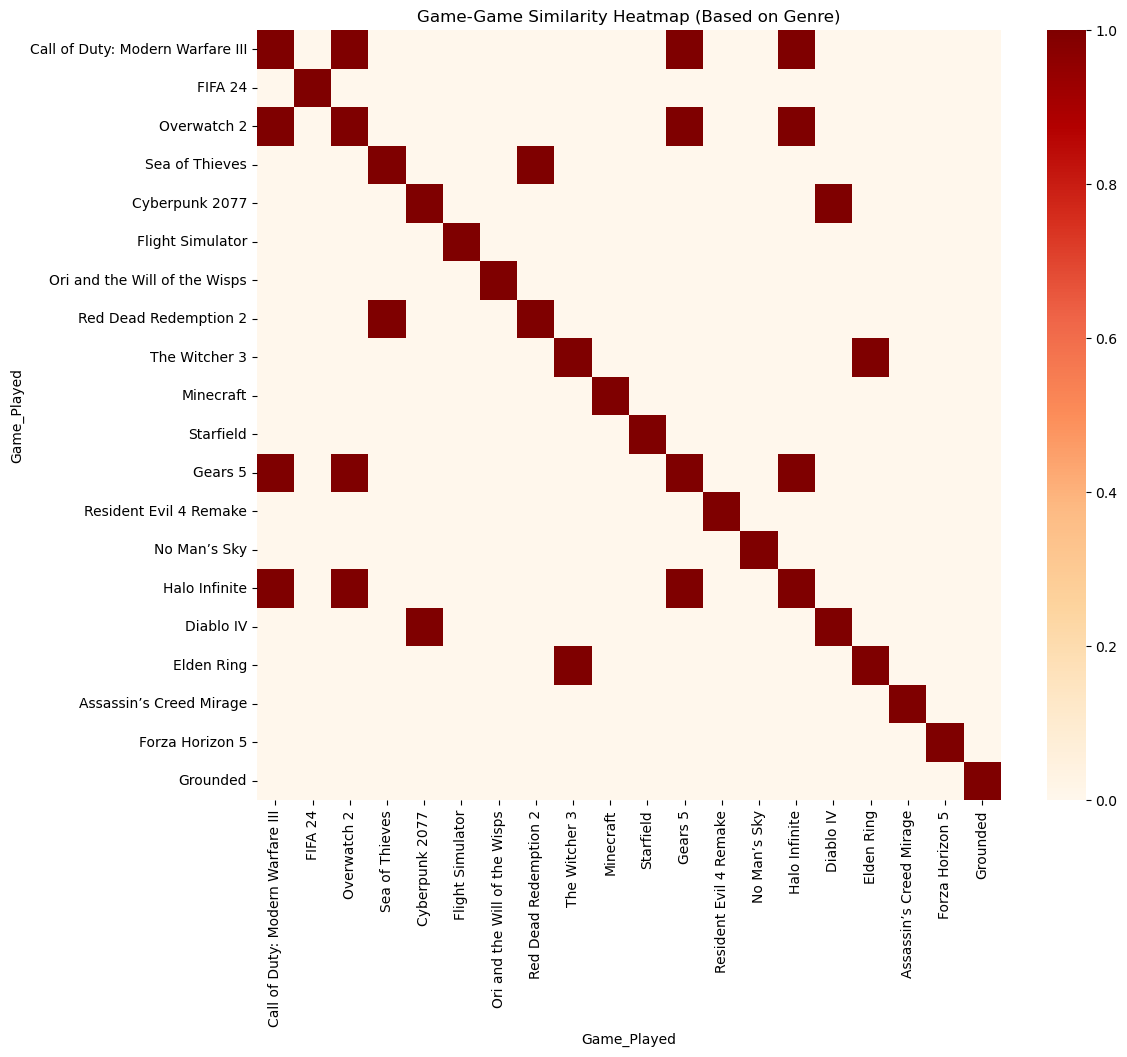

<Figure size 640x480 with 0 Axes>

In [28]:
# 5. Heat Map Visualization (Game vs Game)
item_data = df_cleaned[['Game_Played', 'Genre']].drop_duplicates().set_index('Game_Played')
item_genres = pd.get_dummies(item_data['Genre'])
item_sim = cosine_similarity(item_genres)
item_sim_df = pd.DataFrame(item_sim, index=item_genres.index, columns=item_genres.index)

plt.figure(figsize=(12, 10))
sns.heatmap(item_sim_df, cmap='OrRd')
plt.title('Game-Game Similarity Heatmap (Based on Genre)')
plt.show()
plt.savefig('Content Heatmap 2.png')

In [29]:
# --- Example Usage ---
target_user = "XG0001"
recommendations = recommend_games(target_user, df_cleaned, game_genre_matrix)
print(f"Genre-Centered Recommendations for User {target_user}:")
print(recommendations[['Game', 'Similarity_Score']].to_string(index=False))

Genre-Centered Recommendations for User XG0001:
                 Game  Similarity_Score
              Gears 5          0.633014
        Halo Infinite          0.633014
Red Dead Redemption 2          0.507802


### Option 3: Hybrid Recommendation System

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer


In [31]:
# 1. Load the Data
df = pd.read_csv('Dataset.csv')


# 2. Preprocess Data for Content-Based Filtering
# Create a dataset of unique games and their genres
games_df = df[['Game_Played', 'Genre']].drop_duplicates().set_index('Game_Played')

# Use CountVectorizer to turn text Genres (e.g., "Action RPG") into vectors
# This allows "Action RPG" to have similarity with "Action" and "RPG" games separately
count_vect = CountVectorizer()
genre_matrix = count_vect.fit_transform(games_df['Genre'])

# Calculate Cosine Similarity based on Genre
content_sim = cosine_similarity(genre_matrix, genre_matrix)
content_sim_df = pd.DataFrame(content_sim, index=games_df.index, columns=games_df.index)


# 3. Preprocess Data for Collaborative Filtering
# Create a User-Item Matrix (Rows=Users, Cols=Games, Values=Ratings)
# We fill missing values with 0 (unplayed)
user_item_matrix = df.pivot_table(index='Gamer_ID', columns='Game_Played', values='Personal_Rating').fillna(0)

# Calculate Item-Item Similarity based on User Ratings
# We look at the correlation between columns (games)
collab_sim = cosine_similarity(user_item_matrix.T) 
collab_sim_df = pd.DataFrame(collab_sim, index=user_item_matrix.columns, columns=user_item_matrix.columns)


# 4. Create the Hybrid Model
# Combine the two matrices. You can adjust weights to favor one method.
weight_content = 0.7
weight_collab = 0.3

hybrid_sim_df = ((weight_content * content_sim_df) + (weight_collab * collab_sim_df)).round(2)


# 5. Define the Recommendation Function
def get_hybrid_recommendations(user_id, top_n=5):
    # Check if user exists
    if user_id not in user_item_matrix.index:
        return "User not found."
    
    # Get the user's current ratings
    user_ratings = user_item_matrix.loc[user_id]
    
    # Identify games the user has played (rating > 0) vs not played
    played_games = user_ratings[user_ratings > 0].index.tolist()
    unplayed_games = user_ratings[user_ratings == 0].index.tolist()
    
    # Dictionary to store predicted ratings for unplayed games
    predicted_ratings = {}
    
    for game in unplayed_games:
        # Get similarity scores between this unplayed game and all games the user PLAYED
        sim_scores = hybrid_sim_df.loc[game, played_games]
        
        # Get the user's actual ratings for those played games
        user_actual_ratings = user_ratings[played_games]
        
        # Calculate Weighted Average: Sum(Similarity * Rating) / Sum(Similarity)
        numerator = np.dot(sim_scores, user_actual_ratings)
        denominator = sim_scores.sum()
        
        if denominator > 0:
            predicted_ratings[game] = numerator / denominator
        else:
            predicted_ratings[game] = 0
            
    # Sort games by predicted rating in descending order
    recommendations = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    return recommendations

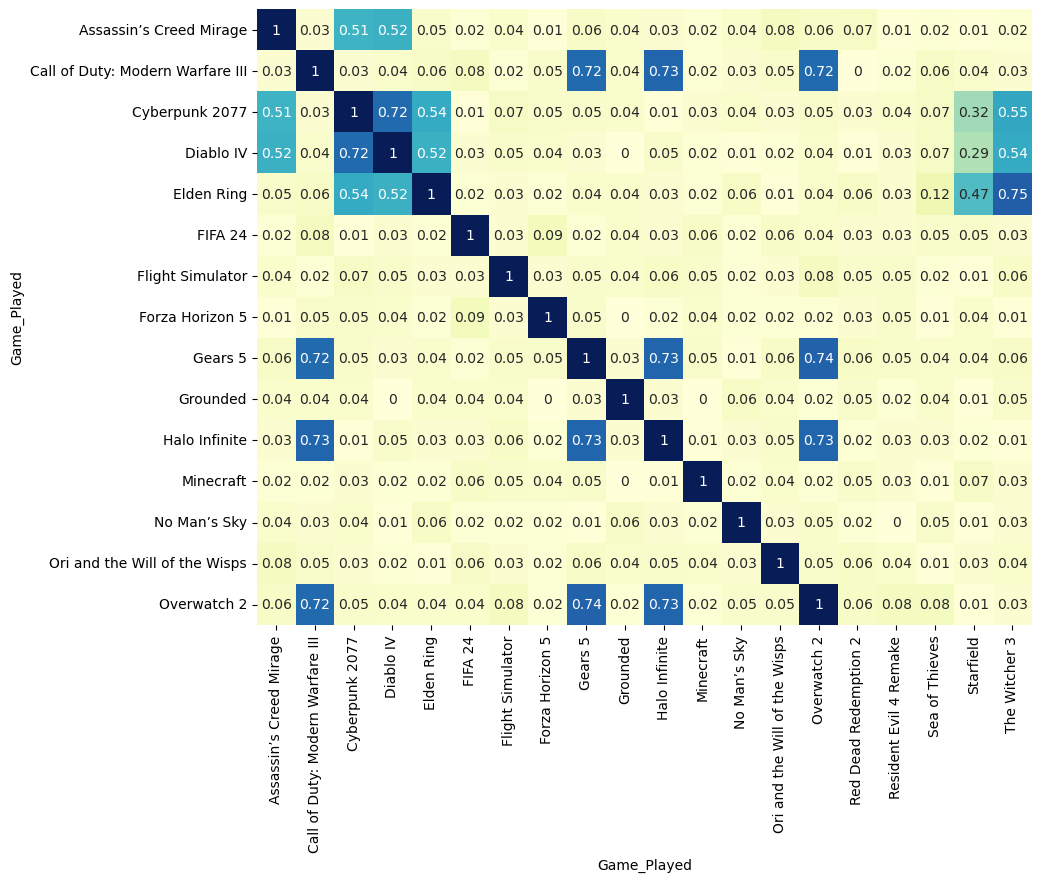

<Figure size 640x480 with 0 Axes>

In [32]:
# 7. Heat Map
plt.figure(figsize=(10, 8))
sns.heatmap(hybrid_sim_df.head(15), annot=True, cmap="YlGnBu", cbar=False)
plt.show()

plt.savefig('Hybrid Heatmap.png')

In [18]:
# --- Example Usage ---
sample_user = 'XG0001'
recommendations = get_hybrid_recommendations(sample_user)

print(f"Top Recommendations for {sample_user}:")
for game, score in recommendations:
    print(f"- {game} (Predicted Score: {score:.2f})")

Top Recommendations for XG0001:
- Red Dead Redemption 2 (Predicted Score: 7.12)
- Minecraft (Predicted Score: 6.90)
- Forza Horizon 5 (Predicted Score: 6.79)
- Starfield (Predicted Score: 6.72)
- Grounded (Predicted Score: 6.47)
